# 12：ハイパーパラメータの探索と検証データ


---
## 目的
CNNを用いたMNISTデータセット文字認識を通じて，ハイパーパラメータの探索・検証および検証データの役割について理解する．

また，ここではGPUを用いたネットワークの計算を行う．


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．


In [21]:
# モジュールのインポート
import os
from time import time
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

import gzip
from random import randint

import matplotlib.pyplot as plt

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットのダウンロードと読み込みと学習サンプルの削減


まずはじめに，`wget`コマンドを使用して，MNISTデータセットをダウンロードします．

In [2]:
!wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -O train-images-idx3-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -O train-labels-idx1-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -O t10k-images-idx3-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -O t10k-labels-idx1-ubyte.gz

次に，ダウンロードしたファイルからデータを読み込みます．詳細は前回までのプログラムを確認してください．

今回は2次元の画像データとしてMNISTデータセットを扱うため，
データを`(チャンネル, 縦，横)`の形に並べ替えます．

In [3]:
# load images
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), np.uint8, offset=16)
x_train = x_train.reshape(-1, 784)

with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
    x_test = np.frombuffer(f.read(), np.uint8, offset=16)
x_test = x_test.reshape(-1, 784)

with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 1, 28, 28) (60000,)
(10000, 1, 28, 28) (10000,)


## 検証データの作成

ネットワークの学習やモデルの定義には多くのハイパーパラメータが存在します．例えば，
* ネットワークのハイパーパラメータ
  * 中間層の層数
  * 中間層のユニット数
  * Dropoutを適用するかどうか（Dropoutを用いる場所やdropout ratio）
  * Batch Normalizationを適用するかどうか

* 学習のハイパーパラメータ
  * 学習率
  * 学習回数
  * ミニバッチサイズ

などが挙げられます．

最適なハイパーパラメータを決定するために使用するデータを**検証データ（validation data）**と呼びます．

MNISTデータセットには学習データ（train data）とテストデータ（test data）しか存在しません．このように，専用の検証データが存在しないデータセットや個人が作成したオリジナルのデータセットでは，学習データの一部を検証データとして使用します．

以下では，MNISTデータセットの学習データを分割し，学習および検証データを作成します．
まず，検証データに使用するデータの割合を`validation_ratio`として定義します．
今回は学習データの20%を検証データとして使用することとし，0.2と指定します．
この割合に基づいて，学習データの20%となるサンプル数を`n_val`として計算します．

その後，学習および検証データになるよう，データを分割します．

実行すると，60000枚の学習サンプルの20%である12000枚が検証データ，残りの80%の48000枚が学習データになるよう分割されていることがわかります．


In [4]:
validation_ratio = 0.2   # 検証に使用するデータの割合
n_train_original = x_train.shape[0]
n_val = int(n_train_original * validation_ratio)

# 検証データ
x_val = x_train[0:n_val]
y_val = y_train[0:n_val]

# 学習データ
x_train = x_train[n_val:]
y_train = y_train[n_val:]

print("train      :", x_train.shape, y_train.shape)
print("validation :", x_val.shape, y_val.shape)
print("test       :", x_test.shape, y_test.shape)

train      : (48000, 1, 28, 28) (48000,)
validation : (12000, 1, 28, 28) (12000,)
test       : (10000, 1, 28, 28) (10000,)


## ネットワークモデルの定義
畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

１層目の畳み込み層は入力チャンネル数が１，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．２層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．１つ目の全結合層は入力ユニット数は不定とし，出力は1024としています．次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．これらの各層の構成を`__init__`関数で定義します．

次に，`forward`関数では，定義した層を接続して処理するように記述します．`forward`関数の引数xは入力データです．それを`__init__`関数で定義したconv1に与え，その出力を活性化関数であるrelu関数に与えます．そして，その出力をmax_pooling_2dに与えて，プーリング処理結果をhとして出力します．hはconv2に与えられて畳み込み処理とプーリング処理を行います．そして，出力hをl1に与えて全結合層の処理を行います．最終的にl3の全結合層の処理を行った出力hを戻り値としています．

In [5]:
class CNN(nn.Module):
    def __init__(self, n_channels=1, filter_size=3, num_kernel=64, hidden_size=128):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, num_kernel, kernel_size=filter_size, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.l1 = nn.Linear(int(28/2) * int(28/2) * num_kernel, hidden_size)
        self.l2 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        h = self.relu(self.conv(x))
        h = self.pool(h)
        h = h.view(h.size()[0], -1)
        h = self.relu(self.l1(h))
        h = self.l2(h)
        return h

## 学習およびハイパーパラメータ探索の準備




### 探索時に共通するパラメータの設定

まずはじめに，探索時に共通するパラメータを定義します．
具体的には，入力層のユニット数`input_size`および出力層のユニット数`output_size`は，探索時には共通であるため，事前に定義しておきます．
また，学習，検証データのサンプル数もすでに決まっているため，変数として定義しておきます．

In [11]:
input_size = x_train.shape[1]
output_size = 10

num_train_data = x_train.shape[0]
num_val_data = x_val.shape[0]
num_test_data = x_test.shape[0]

### 探索するパラメータの設定

次に，検証データを用いて最適な値を求めたいパラメータを定義します．

ここでは，中間層のユニット数の最適な値を`[32, 64, 128, 256]`の中から求めるものとし，他のパラメータは固定します．

また，パラメータの探索には複数回の学習を行う必要があり計算に多くの時間を要します．
ここでは，実習中の計算時間削減のために，学習エポック数を10と小さい値に設定します．




In [16]:
n_hidden = 64

channel_list = [32, 64, 128, 256]

batch_size = 100
n_iter = num_train_data / batch_size

learning_rate = 0.01
# learning_rate_list = [0.1, 0.05, 0.01, 0.005, 0.001]

epoch_num = 10

learning_rate = 0.01

## ハイパーパラメータ探索

ハイパーパラメータ探索を行います．

まず，各パラメータでの結果を保存するためのリスト`param_search_list`を作成します．

次に，for文を用いて探索したいハイパーパラメータを一つづつ指定し，ネットワークの学習と検証データでの精度を求めます．
ネットワークの学習プログラムは前回までのもの同様のため詳細は割愛します．

学習が終了すると，探索したパラメータの値やその時の誤差および精度の推移のデータを辞書型オブジェクト`result`に格納し，それを`param_search_list`に保存します．

これを繰り返すことで，各パラメータの値を用いた場合の精度や学習推移を確認比較することが可能となり，より精度の高いネットワークを構築するためのあたりをつけることができます．

In [19]:
param_search_list = []

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

for channel_size in channel_list:
    model = CNN(num_kernel=channel_size, hidden_size=n_hidden)
    if use_cuda:
        model.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    epoch_list = []
    train_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    # ネットワークを学習モードへ変更
    model.train()

    iteration = 1
    for epoch in range(1, epoch_num+1):
        count, sum_loss = 0.0, 0.0
        
        perm = np.random.permutation(num_train_data)
        for i in range(0, num_train_data, batch_size):
            x_batch = x_train[perm[i:i+batch_size]]
            y_batch = y_train[perm[i:i+batch_size]]

            x_batch = torch.from_numpy(x_batch).type(torch.float32)
            y_batch = torch.from_numpy(y_batch).type(torch.int64)

            if use_cuda:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y = model(x_batch)

            loss = criterion(y, y_batch)
            
            model.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            pred = torch.argmax(y, dim=1)
            count += torch.sum(pred == y_batch)

            iteration += 1
            
        # 検証データでの精度の確認
        val_correct_count = 0
        for i in range(num_val_data):
            input = x_val[i:i+1]
            label = y_val[i:i+1]
            input = torch.from_numpy(input).type(torch.float32)
            label = torch.from_numpy(label).type(torch.int64)
            if use_cuda:
                input = input.cuda()
                label = label.cuda()
            y = model(input)
            pred = torch.argmax(y)
            if pred == label:
              val_correct_count += 1

        # 学習途中のlossと精度の保存
        epoch_list.append(epoch)
        train_loss_list.append(sum_loss / num_train_data)
        train_accuracy_list.append(count / num_train_data)
        val_accuracy_list.append(val_correct_count / num_val_data)
            
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch,
                                                                  sum_loss / n_iter,
                                                                  count.item() / num_train_data))

    # 探索した結果の保存
    result = {'lr': learning_rate, 'n_hidden': hidden_size,
              'val_acc': val_accuracy_list,
              'train_acc': train_accuracy_list,
              'train_loss': train_loss_list}
    param_search_list.append(result)
    print(result['lr'], result['n_hidden'], result['train_acc'][-1], result['val_acc'][-1])

epoch: 1, mean loss: 5.801198113958041, mean accuracy: 0.11070833333333334
epoch: 2, mean loss: 2.301567466557026, mean accuracy: 0.1123125
epoch: 3, mean loss: 2.3015377685427665, mean accuracy: 0.1123125
epoch: 4, mean loss: 2.3015434836347897, mean accuracy: 0.1123125
epoch: 5, mean loss: 2.301543753345807, mean accuracy: 0.1123125
epoch: 6, mean loss: 2.3015665675203008, mean accuracy: 0.1123125
epoch: 7, mean loss: 2.301526995996634, mean accuracy: 0.1123125
epoch: 8, mean loss: 2.3015160014232, mean accuracy: 0.1123125
epoch: 9, mean loss: 2.3014908879995346, mean accuracy: 0.1123125
epoch: 10, mean loss: 2.301573272546132, mean accuracy: 0.1123125
0.01 32 tensor(0.1123, device='cuda:0') 0.11258333333333333
epoch: 1, mean loss: 11.05497078044961, mean accuracy: 0.4898125
epoch: 2, mean loss: 0.6221847544113795, mean accuracy: 0.8026458333333333
epoch: 3, mean loss: 0.5348543929246564, mean accuracy: 0.836375
epoch: 4, mean loss: 0.5159887901196877, mean accuracy: 0.8415
epoch: 5,

KeyboardInterrupt: ignored

## 探索結果の確認

`param_search_list`に保存しておいた各ハイパーパラメータに対する結果を確認します．

まず，各結果の数値をprintします．
その後，各パラメータでの学習推移（検証データ）をプロットし比較します．

lr: 0.01 hidden size 32 train accuracy: tensor(0.1123, device='cuda:0') validation accuracy: 0.11258333333333333
lr: 0.01 hidden size 64 train accuracy: tensor(0.8586, device='cuda:0') validation accuracy: 0.8538333333333333


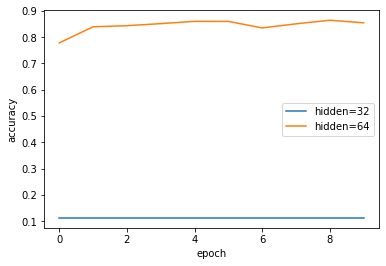

In [22]:
# 学習結果の表示
for ps in param_search_list:
    print("lr:", ps['lr'],
          "hidden size", ps['n_hidden'],
          "train accuracy:", ps['train_acc'][-1],
          "validation accuracy:", ps['val_acc'][-1])

# グラフプロット
plt.figure()
for ps in param_search_list:
    plt.plot(ps['val_acc'], label='hidden=%d' % ps['n_hidden'])
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.legend()            # 凡例
plt.show()

## 課題
1. 他のパラメータについても探索をして最適な値を見つけよう
2. 複数種類のパラメータの最適な組み合わせを求めよう